In [22]:
# Importing libraries
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import utilities as utils
from torch import Tensor
from typing import Callable

from tqdm import tqdm # to compute the time bar

In [2]:
# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Introduction

## Effective Couplings of the Restricted Boltzmann Machine

<p align="center">
<img src="https://github.com/DsysDML/couplings_inference/blob/main/figures/RBM_figure.png?raw=true" alt="RBM figure" width="50%">
</p>

**Fig-1. Architecture of the Potts-Bernoulli Restricted Boltzmann Machine (PB-RBM).** Bitartite lattice with hidden variables $h_a$, that can take only two possible values (typically 0 an 1); visible variables $v_i$ take on $q$ different states or colors.

The RBM is an energy-based model estructured as bipartite neural network. In this model, the visible layer $\boldsymbol{v} \!=\! \{ v_i \}_{i=1}^{N_v}$ represents the data, while the hidden layer $\boldsymbol{h} \!=\! \{ h_i \}_{i=1}^{N_h}$ accounts the interactions among the visible variables. The probability of a given RBM configuration $\{ \boldsymbol{v}, \boldsymbol{h} \}$ is determined by the Boltzmann distribution i.,e.
$$
p(\boldsymbol{v}, \boldsymbol{h}) \!\propto\! e^{-\mathcal{H}(\boldsymbol{v}, \boldsymbol{h})},
$$
where $\mathcal{H} (\boldsymbol{v}, \boldsymbol{h})$ is the _energy function_ or _Hamiltonian_. Here, we define the hidden nodes as Bernoulli variables, i.e., $h_a \!\in\! \{0,1\}$, and visible nodes as categorical variables, or Potts "spins", which can take on $q$ states, i.e., $v_i \!\in\! \{1, \dots, q \}$. Hence, the Hamiltonian of such a model is 

$$
\mathcal{H}(\boldsymbol{v}, \boldsymbol{h}) = -\sum_{i, a, \mu} W_{ia}^{\mu} h_a \delta_{\mu}^{v_i} - \sum_{i, \mu} b_{i}^{\mu} \delta_{\mu}^{v_i} - \sum_{a} c_a h_a.
\tag{1}
$$

In the above we used $\delta$ to denote the Kronecker delta, and $\boldsymbol{\Theta} \!\equiv\! \{ \boldsymbol{W}, \boldsymbol{b}, \boldsymbol{c} \}$ are the model parameters. Marginalizing Eq. $(1)$ one can obtain the following Hamiltonian:

$$
\mathcal{H}(\boldsymbol{v}) =  - \sum_{i,\mu} b_i^\mu \delta_\mu^{v_i} - \sum_a \ln \left(1 + e^{ c_a + \sum_{i, \mu} W_{ia}^{\mu} \delta_\mu^{v_i}} \right).
\tag{2}
$$

In the Ref. [1], we expanded Eq. $(2)$ as

$$
\mathcal{H} (\boldsymbol{v}) 
= - \sum_{i, \mu} H_i^\mu \delta_\mu^{v_i} - \sum_{1 \le i_1 < i_2 \le N_v} \sum_{\mu_1, \mu_2} \! \! J_{ i_1 i_2}^{\mu_1 \mu_2} \delta_{\mu_1}^{v_{i_1}} \delta_{\mu_2}^{v_{i_2}} + \sum_{1 \le i_1 < i_2 < i_3 \le N_v} \sum_{\mu_1, \mu_2, \mu_3} J_{ i_1 i_2 i_3}^{\mu_1 \mu_2 \mu_3} \delta_{\mu_1}^{v_{i_1}} \delta_{\mu_2}^{v_{i_2}} \delta_{\mu_3}^{v_{i_3}} \dots,
$$

with effective couplings (in the zero-sum gauge) given by

$$
J_{i_1 \dots i_n}^{\mu_1 \dots \mu_n}  
    = \sum_{K \subseteq [n] } (-1)^{n - |K|} \Bigg[
    \frac{1}{q^{N_v}} \sum_{\mu'_1, \dots, \mu'_{N_v}} \sum_a  
     \ln \left( 1 + e^{c_a +  \sum_{ k \in K } W_{i_k a}^{\mu_k} + \sum_{ l \in [N_v] \setminus K} W_{i_l a}^{\mu'_l} } \right) \Bigg],
\tag{3}
$$

where $[n] \equiv \{1,2, \dots, n \}$. **

## Gaussian Approximation

Since Eq. $(3)$ introduces sums of $q^N$ terms, which cannot be done exactly, we must rely on approximations of such expressions. Thus, We can rewrite Eq. $(3)$ as

$$
J_{i_1 \dots i_n}^{\mu_1 \dots \mu_n}  = \sum_{K \subseteq [n]} (-1)^{n-|K|} \frac{1}{q^n} \sum_{\mu'_1, \dots, \mu'_n} \sum_{a} \mathbb{E}_{x \sim X_a^{\setminus \{ i_1 \dots i_n \}}} \left[ \ln \left( 1 + e^{c_a + \sum_{k \in K} W_{i_k a}^{\mu_k} + \sum_{l \in [n] \setminus K} W_{i_l a}^{\mu'_l} + x  } \right)  \right], \tag{4}
$$

where $X_a^{ \setminus \{ i_1, \dots, i_n \}} \coloneqq \sum_{l = n+1}^{N_{v}} \! {W}_{i_l a}^\ast$ is the random variable with each ${W}_{i_l a}^\ast$ drawn uniformly from $\{ {W}_{i_l a}^\mu : \mu \in [q] \}$. 

Fixing the zero-sum gauge of the RBM parameters (i.e., $\sum_{\mu=1}^q \hat{W}_{i a}^\mu = 0, \ \forall i$), implies setting the mean and the variance of $X_a^{ \setminus \{ i_1, \dots, i_n \}}$ as  $$\mathbb{E}[x] \!=\! 0 \ \ \mathrm{and}  \ \ \mathrm{Var} [x] \!=\! q^{-1} \sum_{l=n+1}^{N_{v}} \sum_{\mu=1}^q  \left( \hat{W}_{i_l a}^{\mu} \right)^2. $$

On a first approximation based on the central limit theorem, and for sufficiently large $N_v$ with small $n$, the expected values in Eq. (4) are regarded as Gaussian integrals. Hence, normalizing $X_a^{\setminus \{i_1, \dots, i_n\}}$ to unit variance, we approximate the expected values of in right-hand side of Eq. (4) as

$$
\mathbb{E}_{x \sim X_a^{\setminus \{ i_1 \dots i_n \}}} \left[ \ln \left( 1 + e^{c_a + \sum_{k \in K} W_{i_k a}^{\mu_k} + \sum_{l \in [n] \setminus K} W_{i_l a}^{\mu'_l} + x  } \right)  \right] 
\approx
\int_{-\infty}^{\infty} Dz \, 
    \ln \left( 1 + e ^{ 
        c_a + \sum_{k=1}^n \hat{W}_{i_k a}^{\mu'_k} 
        + \sqrt{ q^{-1} \sum_{l=n+1}^{N_v} \sum_{\mu=1}^q 
            \big( \hat{W}_{i_l a}^{\mu} \big)^2 } \ z } \right),
\tag{5}
$$

where $Dz = {e^{-z^2/2}}/{\sqrt{2\pi}} \ dz.$ 

**In the following we will numerically implement Eq. $(5)$ on GPUs to compute the effective fields, 2-, and 3-body couplings efficiently.

## Loading a PB-RBM model

Let us use an RBM model trained on Multiple Sequence Alignment data (PF00072) to test our functions.

In [3]:
model_fname = 'PottsBernoulliRBM_PCD-10_mbs=5000_lr=0.01_Nh=1000_centered.h5'

# selecting an update to observe
update = 51480
with h5py.File('models/'+ model_fname, 'r') as f:
    n_upd = f['UpdByEpoch'][()]
    ep = int(update/n_upd)
    W = f['W' + str(ep)][:,:,:].astype(np.float64)  # shape: q x Nv x Nh
    b = f['vbias' + str(ep)][:,:].astype(np.float64)  # shape: q x Nv
    c = f['hbias' + str(ep)][:].astype(np.float64)  # shape: Nh 

In [4]:
# RBM Fixing Gauge
def fix_gauge_RBM(W: Tensor, 
                  b: Tensor, 
                  c: Tensor, 
                  gauge: str ='zero-sum') -> None:
    """
    a Function to fix the gauge in Potts-Bernoulli RBMs

    Args:
        W (Tensor): weight matrix (dim: q x Nv x Nh).
        b (Tensor): visible bias (dim: q x Nv).
        c (Tensor): hidden bias (dim: Nh).
        gauge (str): name of the gauge that is going to be fixed. 
            It could be either 'zero-sum' or 'lattice-gas'.
    
    Returns:
        None
    """

    if gauge == 'zero-sum':
        A = W.mean(axis=0)
        bt = b.mean(axis=0)

    elif gauge == 'lattice-gas':
        # the zero is set in the last color
        A = W[-1,:,:]
        bt= b[-1,:]
    else:
        return 'Gauge does not exist'
    
# It is important to fix the zero-sum gauge in the RBM to get accurate results!
fix_gauge_RBM(W, b, c)

# Torch Functions

Now we implement the functions we need to extract the couplings.

## Auxiliary Functions

In [5]:
# auxiliary function to set the device of the RBM parameters
def set_device(W: Tensor, 
               b: Tensor, 
               c: Tensor, 
               cuda: bool =True, 
               cuda_device: str = 'cuda:0') -> tuple[Tensor, Tensor, Tensor]:
    """
    Set the device of RBM paramters.
    
    Args:
        W, b, c: parameters of the RBM.
        cuda: if true it uses cuda, otherwise it uses cpu.
    
    Returns:
        None
    """
    
    if cuda and torch.cuda.is_available():
        device = cuda_device
    else:
        device = 'cpu'
    
    # loading model paraters
    W_torch = torch.from_numpy(W).to(device)
    b_torch = torch.from_numpy(b).to(device)
    c_torch = torch.from_numpy(c).to(device)
    
    return W_torch, b_torch, c_torch    

# Gaussian function in torch 
def gaussian(x: Tensor) -> Tensor:
    """
    It returns the value of a standard gaussian function.
    
    Args:
        x: variable at which the gaussian function in evaluated.

    Returns:
        Tensor: exp(-(x^2)/2)/sqrt(2*pi)
    """
    return torch.exp(-0.5 * x**2) / math.sqrt(2 * math.pi)

# softmax function in torch
def softplus(x: Tensor) -> Tensor:
    """
    It computes ln(1 + exp(x)).
    
    Args:
        x: variable at which the function is evaluated.

    Returns:
       Tensor: ln(1 + exp(x))
    """
    return torch.log(1 + torch.exp(x))

# estimating the average using a numeric Gaussian integral
def est_gaussian_avg(f: Callable, 
                     loc: Tensor, 
                     scale: Tensor, 
                     n_sigma: float, 
                     n_steps: int,
                     sum_last_dim: bool = True) -> Tensor:
    """Implement the trapezoid rule of integration to approximate the average 
       of a function over a Gaussian meassure.

    Args:
        f (Function): function to average.
        loc (Tensor): location parameter (or mean) of the Gaussian.
        scale (Tensor): scale parameter (or the standard deviation) of 
            the Gaussian.
        n_sigma (float): set the wide of the numerical integral in terms 
            of the scale parameter.
        n_steps (int): number of steps of the numerical integral.
        sum_last_dim (bool): If true, sums over the last dimension.
    
    Returns:
        Tensor: value of the integral of f between -n_sigma*scale and n_sigma*scale under the gaussian measure.
    """
    # numerical integration
    beta = torch.tensor(n_sigma,
                        dtype = scale.dtype, 
                        device = scale.device)
    alpha = -beta 
    h = (beta-alpha)/n_steps
    I = 0.5*(f(alpha*scale + loc)*gaussian(alpha) 
             + f(beta*scale + loc)*gaussian(beta))
    
    # numerical integral
    for k in range(1, n_steps):
        z = alpha + k*h
        I += f(z*scale + loc)*gaussian(z)
    
    # this sum is useful when the last dimension are the hidden nodes
    if sum_last_dim:
        return torch.sum(h*I, dim=-1)
    else:
        return h*I

## Fields

Here we implement a formula to compute the Gaussian approximation of the field tensor whose elements are given by

$$
\hat{H}_i^\mu = \hat{b}_i^\mu + \hat{J}_i^\mu. 
\tag{7}
$$ 

Following the procedure given above for $n=1$, we leverage the parallelization in GPU to compute a tensor such that
$$
T_{i}^{\mu'} = \sum_a \int_{-\infty}^{\infty} Dz \ \ln \left( 1 + e^{c_a + \hat{W}_{ia}^{\mu'} + \sqrt{q^{-1} \sum_{j (\neq i)} \sum_\mu (\hat{W}_{ja}^{\mu}})^2 \ z } \right).
\tag{8}
$$
Then, we can approximate $J_i^\mu$ by
$$
J_i^\mu \approx T_i^\mu - \frac{1}{q} \sum_{\mu'} T_{i}^{\mu'}.
\tag{9}
$$
Finally, we can compute $H_i^\mu$ by replacing $(9)$ in $(7)$.

In [6]:
# fields functions
def T1_zs(W: Tensor, 
          c: Tensor, 
          n_sigma: float, 
          n_steps: int) -> Tensor:
    """
    It computes a 2-rank tensor whose entries are given by the Eq. (8).
    
    Args:
        W (Tensor): weight matrix (shape: q x Nv x Nh).
        c (Tensor): hidden fields (shape: Nh).
        n_sigma (float): set the wide of the numerical integral in terms of the scale parameter of the gaussian.
        n_steps (int): number of steps of the numerical integral.
    
    Returns:
        Tensor: 2-rank tensor whose entries are defined in Eq. (8) (shape: q x Nv).
    """
    q = W.shape[0]
    
    # bias of the softmax function
    bias = W + c

    # scale parameter of the Gaussian measure
    sd = torch.sqrt((torch.sum(W**2, dim=(0,1)) - torch.sum(W**2, dim=0))/q)

    return est_gaussian_avg(f=softplus, 
                            loc=bias, 
                            scale=sd, 
                            n_sigma=n_sigma, 
                            n_steps=n_steps) # shape: q x Nv

def H_zs(W: Tensor, 
         b: Tensor, 
         c: Tensor, 
         n_sigma: float, 
         n_steps: int) -> Tensor:
    """
    It computes a q x Nv effective field matrix.
    
    Args:
        W (Tensor): weight matrix (shape: q x Nv x Nh)  
        b (Tensor): Visible fields (shape: q x Nv)
        c (Tensor): hidden fields (shape: Nh)
        n_sigma (float): set the wide of the numerical integral in terms of the scale parameter of the gaussian.
        n_steps (int): number of steps of the numerical integral.

    Returns:
       Tensor: 2-rank tensor of effective fields (shape: q x Nv).
    """
    T1_torch = T1_zs(W, c, n_sigma, n_steps)
    
    return (T1_torch - T1_torch.mean(dim=0) + b) # shape: q x Nv

In [7]:
# RBM parameters
W_torch, b_torch, c_torch = set_device(W, b, c, cuda=True)

# parameters of numerical integral 
n_sigma = 5
n_steps = 20

In [8]:
%%timeit
h_torch = H_zs(W_torch, b_torch, c_torch, n_sigma, n_steps) # q x Nv
torch.cuda.synchronize()
#print(h_torch)

14.2 ms ± 210 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 2-Body Couplings

Analogously, for 2-body couplings we can write
$$
T_{i_1 i_2}^{\mu'_1 \mu'_2} = \sum_a \int_{-\infty}^{\infty} Dz \ \ln \left( 1 + e^{c_a + \hat{W}_{i_1 a}^{\mu'_1} + \hat{W}_{i_2 a}^{\mu'_2} + \sqrt{q^{-1} \sum_{j (\neq i_1, i_2)} \sum_\mu (\hat{W}_{ja}^{\mu} )^2 } \ z } \right).
\tag{10}
$$
Thus, we can approximate $J_{i_1 i_2}^{\mu_1 \mu_2}$ by
$$
J_{i_1 i_2}^{\mu_1 \mu_2} \approx T_{i_1 i_2}^{\mu_1 \mu_2} - \frac{1}{q} \left[ \sum_{\mu'_1} T_{i_1 i_2}^{\mu'_1 \mu_2} + \sum_{\mu'_2} T_{i_1 i_2}^{\mu_1 \mu'_2} \right] + \frac{1}{q^2} \sum_{\mu'_1, \mu'_2} T_{i_1 i_2}^{\mu'_1 \mu'_2}.
\tag{11}
$$

In [9]:
# 2-body couplings functions
def T2_zs(W: Tensor, 
          c: Tensor, 
          i1: int, 
          i2: int, 
          n_sigma: float, 
          n_steps: int) -> Tensor:
    """
   It computes the 2-rank tensor whose entries are given by the Eq. (10) for sites i1, i2.
    
    Args:
        W (Tensor): weight matrix (shape: q x Nv x Nh).    
        c (Tensor): hidden fields (shape: Nh).
        i1, i2 (int): visible site index 1, 2.
        n_sigma (float): set the wide of the numerical integral in terms of the scale parameter of the gaussian.
        n_steps (int): number of steps of the numerical integral.

    Returns:
        Tensor: 2-rank tensor whose entries are defined in Eq. (10) (shape: q x q).
    """
    W1 = W[:,i1,:]
    W2 = W[:,i2,:]
    q = W.shape[0]

    # bias of the softmax function
    bias = W1.unsqueeze(1) + W2.unsqueeze(0) + c

    # scale parameter of the Gaussian measure
    sd = torch.sqrt((torch.sum(W**2, dim=(0,1)) 
                     - torch.sum(W1**2, dim=0)
                     - torch.sum(W2**2, dim=0)
                    )/q)
    
    return est_gaussian_avg(f=softplus, 
                            loc=bias, 
                            scale=sd, 
                            n_sigma=n_sigma, 
                            n_steps=n_steps) # shape: q x q

def J2_zs(W: Tensor, 
          c: Tensor, 
          i1: int, 
          i2: int, 
          n_sigma: float, 
          n_steps: int) -> Tensor:
    """
    It computes the 2-rank pairwise coupling tensor between sites i1, i2.
    
    Args:
        W (Tensor): weight matrix (shape: q x Nv x Nh)    
        c (Tensor): hidden fields (shape: Nh)
        i1, i2 (int): visible site index 1, 2
        n_sigma (float): set the wide of the numerical integral in terms of the scale parameter of the gaussian.
        n_steps (int): number of steps of the numerical integral

    Returns:
      Tensor: 2-rank pairwise coupling tensor between sites i1, i2 (shape: q x q).
    """
    T2_torch = T2_zs(W, c, i1, i2, n_sigma, n_steps)
    J2_torch = (T2_torch + T2_torch.mean()
                - T2_torch.mean(dim=0).unsqueeze(0) 
                - T2_torch.mean(dim=1).unsqueeze(1) 
               )
    
    return J2_torch # shape: q x q

In [10]:
# RBM parameters
W_torch, b_torch, c_torch = set_device(W, b, c, cuda=True)

# parameters of numerical integral 
n_sigma = 5
n_steps = 20

In [11]:
%%timeit
J2_torch = J2_zs(W_torch, c_torch, 2, 3, n_sigma, n_steps) # q x q
torch.cuda.synchronize()

3.14 ms ± 62.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
# computating all couplings
q, Nv, _ = W.shape
J2_matrix = np.zeros((q,q,Nv,Nv))
pbar = tqdm(total=int(Nv*(Nv-1)/2), colour='green')
for j1 in range(1, Nv):
    for j2 in range(j1):
        J2_torch = J2_zs(W_torch, c_torch, j1, j2, n_sigma, n_steps)
        J2_matrix[:,:, j1, j2] = J2_torch.to('cpu').numpy()
        pbar.update(1)
pbar.close()

J2_matrix = J2_matrix + J2_matrix.transpose(1,0,3,2)
# This cell runs in < 20s (in an NVIDIA Geforce RTX 3090 GPU)

100%|██████████████████████████████████████| 6216/6216 [00:19<00:00, 313.42it/s]


## 3-body couplings

Finally, the analogous expressions for 3-body couplings are given by

$$
T_{i_1 i_2 i_3}^{\mu'_1 \mu'_2 \mu'_3} = \sum_a \int_{-\infty}^{\infty} Dz \ \ln \left( 1 + e^{c_a + \hat{W}_{i_1 a}^{\mu'_1} + \hat{W}_{i_2 a}^{\mu'_2} + \hat{W}_{i_3 a}^{\mu'_3} + \sqrt{q^{-1} \sum_{j (\neq i_1, i_2, i_3)} \sum_\mu (\hat{W}_{ja}^{\mu} )^2 } \ z } \right).
\tag{12}
$$
Thus, we can approximate $J_{i_1 i_2}^{\mu_1 \mu_2}$ by
$$
\begin{align}
J_{i_1 i_2 i_3}^{\mu_1 \mu_2 \mu_3} 
& \approx T_{i_1 i_2 i_3}^{\mu_1 \mu_2 \mu_3} - \frac{1}{q} \left[ \sum_{\mu'_1} T_{i_1 i_2 i_3}^{\mu'_1 \mu_2 \mu_3} + \sum_{\mu'_2} T_{i_1 i_2 i_3}^{\mu_1 \mu'_2 \mu_3} + \sum_{\mu'_3} T_{i_1 i_2 i_3}^{\mu_1 \mu_2 \mu'_3} \right] \\
& \qquad + \frac{1}{q^2} \left[ \sum_{\mu'_1, \mu'_2, \mu_3} T_{i_1 i_2 i_3}^{\mu'_1 \mu'_2 \mu_3} +  \sum_{\mu'_1, \mu_2, \mu'_3} T_{i_1 i_2 i_3}^{\mu'_1 \mu_2 \mu'_3} + \sum_{\mu_1, \mu'_2, \mu'_3} T_{i_1 i_2 i_3}^{\mu_1 \mu'_2 \mu'_3} \right] - \frac{1}{q^3} \sum_{\mu'_1, \mu'_2, \mu'_3} T_{i_1 i_2 i_3}^{\mu'_1 \mu'_2 \mu'_3}.
\tag{13}
\end{align}
$$

In [13]:
# 3-body couplings functions
def T3_zs(W: Tensor, 
          c: Tensor, 
          i1: int, 
          i2: int, 
          i3: int, 
          n_sigma: float, 
          n_steps: int) -> Tensor:
    """
    It computes the 3-rank tensor whose entries are given by the Eq. (12) for sites i1, i2, i3.
    
    Args:
        W (Tensor): weight matrix (shape: q x Nv x Nh).
        c (Tensor): hidden fields (shape: Nh).
        i1, i2, i3 (int): visible site index 1, 2, 3.
        n_sigma (float): set the wide of the numerical integral in terms of the scale parameter of the gaussian.
        n_steps (int): number of steps of the numerical integral.

    Returns:
        Tensor: 3-rank 3-coupling tensor between sites i1, i2, i3 (shape: q x q x q).
    """
    W1 = W[:,i1,:]
    W2 = W[:,i2,:]
    W3 = W[:,i3,:]
    q = W.shape[0]

    # bias of the softmax function
    bias = (W1.unsqueeze(1).unsqueeze(1) 
            + W2.unsqueeze(1).unsqueeze(0) 
            + W3.unsqueeze(0).unsqueeze(0) 
            + c)

    # scale parameter of the Gaussian measure
    sd = torch.sqrt((torch.sum(W**2, dim=(0,1)) 
                      - torch.sum(W1**2, dim=0)
                      - torch.sum(W2**2, dim=0)
                      - torch.sum(W3**2, dim=0)
                     )/q)

    return est_gaussian_avg(f=softplus, 
                            loc=bias, 
                            scale=sd, 
                            n_sigma=n_sigma, 
                            n_steps=n_steps) # dim: q x q x q

def J3_zs(W:Tensor, 
          c: Tensor, 
          i1: int, 
          i2: int, 
          i3: int, 
          n_sigma: float, 
          n_steps: int) -> Tensor:
    """
    It computes the 3-rank 3-body coupling tensor for sites i1, i2, i3.
    
    Args:
        W (Tensor): weight matrix (shape: q x Nv x Nh).
        c (Tensor): hidden fields (shape: Nh).
        i1, i2, i3 (int): visible site index 1, 2, 3.
        n_sigma (float): set the wide of the numerical integral in terms of the scale parameter of the gaussian.
        n_steps (int): number of steps of the numerical integral.

    Returns:
        Tensor: 3-rank 3-body coupling tensor between sites i1, i2, i3 (shape: q x q x q).
    """
    T3_torch = T3_zs(W, c, i1, i2, i3, n_sigma, n_steps)
    J3_torch = (T3_torch - T3_torch.mean()
                - T3_torch.mean(dim=0).unsqueeze(0) 
                - T3_torch.mean(dim=1).unsqueeze(1) 
                - T3_torch.mean(dim=2).unsqueeze(2) 
                + T3_torch.mean(dim=(1,2)).unsqueeze(1).unsqueeze(2)
                + T3_torch.mean(dim=(0,1)).unsqueeze(0).unsqueeze(1)
                + T3_torch.mean(dim=(0,2)).unsqueeze(0).unsqueeze(2)
               )
    
    return J3_torch # dim: q x q x q

In [14]:
# RBM parameters
W_torch, b_torch, c_torch = set_device(W, b, c, cuda=True)

# parameters of numerical integral 
n_sigma = 5
n_steps = 20
i1, i2, i3 = 109, 10, 30

In [15]:
%%timeit
# Computing 2-body coupling for a triplet (j1, j2, j3)
J3_torch = J3_zs(W_torch, c_torch, i1, i2, i3, n_sigma, n_steps)
torch.cuda.synchronize()

55.1 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Contact Prediction

Finally, we will use the inferred 2-body couplings to conduct a contact prediction analysis. We also compare our results with an state-of-the-art technique: **plmDCA** [2,3].

## Preliminaries

As is standard in DCA analysis, after inferring the 2-body epistatic couplings, we compute the coupling strength between two sites $i$ and $j$ as the Fröbenius norm of the corresponding coupling matrix, given by:

$$
F_{ij}^{(2)} = \sqrt{\sum_{\mu, \nu} \left( J_{ij}^{\mu \nu} \right)^2 }.
\tag{8}
$$

Then, we can achieve an ever better contact prediction performance by implementing the _average-product correction} (APC)_ :

$$
    F_{ij}^\mathrm{APC} = F_{ij}^{(2)} - \frac{\sum_k F_{ik}^{(2)} \sum_{k} F_{kj}^{(2)}}{\sum_{k,l}F_{kl}^{(2)}},
\tag{9}
$$

which intends to minimize any background noise.

In [16]:
# A function to compute the APC correction
def APC_correction(F):
    Nv = F.shape[0]
    a = F.sum(axis=1).reshape(Nv, 1)
    b = F.sum(axis=0).reshape(1, Nv)
    c = F.sum()
    APC = a*b/c

    return F - APC 

In [17]:
# Computing Fröbenius norm from inferred couplings
F2 = np.linalg.norm(J2_matrix[:20,:20,:,:], axis=(0,1))

# Now we apply the APC correction
F2_APC = APC_correction(F2)

# Converting the matrix into a table
F2_table = utils.matrix_to_table(F2_APC)

# customizing the table
F2_table = utils.custom_table(F2_table, ascending=False)

#F2_table.head()

In [18]:
# loading plmDCA scores
plm_table = pd.read_table(f'data/plmDCA_score_PF00072.txt', header=None)
plm_table.columns = ['i', 'j', 'Fplm']
plm_table = utils.custom_table(plm_table, ascending=False, zero_index = False)

#plm_table.head()

In [19]:
# loading residues distance data to test our prediction
distance_raw = pd.read_table('data/PF00072_struct.dat', delimiter=' ', header=None)

# customizing table
distance_table = distance_raw.drop(columns=[2])
distance_table.columns = ['i', 'j', 'r']

distance_table = utils.custom_table(distance_table, ascending=True,  zero_index = False)

#distance_table.head()

## Ploting Contacts

In [20]:
# setting the thresholds
k = 5 # minimum residue distance in the sequence (primary structure) of the protein
threshold = 7.5 # threshold to consider a contact

# creating a contact table

# first we add a column that tell us if the pair is a contac considering the threshold
contact_table = distance_table[['rank','|i-j|']].join(distance_table[['r']] < threshold)

# then we consider a epistatic contact only if the distance in the sequence is greater than k 
contact_table = utils.filter_seq_distance(contact_table, k=k)
num_contacts = contact_table['r'].values.sum()
num_total = int(Nv*(Nv-1)/2)

# we filter also pair whose distance in the sequece is greater than k
F2_table_mod = utils.filter_seq_distance(F2_table, k=k).join(contact_table[['r']])
plm_table_mod = utils.filter_seq_distance(plm_table, k=k).join(contact_table['r'])
print('# contacts:', num_contacts)

# contacts: 2074


100%|█████████████████████████████████████████| 300/300 [00:03<00:00, 94.95it/s]


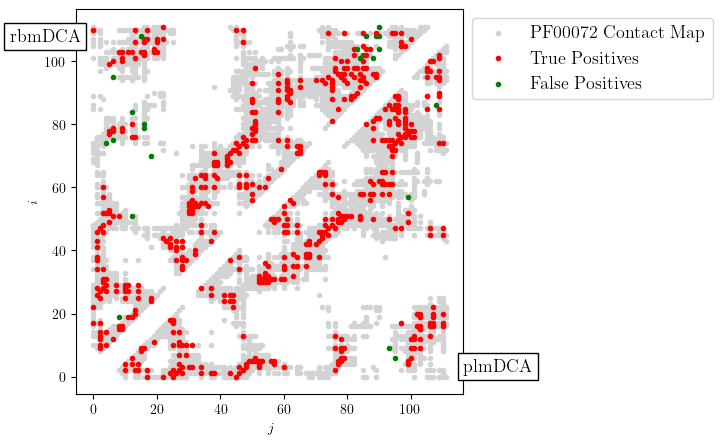

In [21]:
# Let us look at residues pairs with strongest Frobenius norm
num_contacts_F2 = 300

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)

# setting couters to 0
num_F2 = 0
num_F2_false = 0
num_plm = 0
num_plm_false = 0

# plotting true contacts 
pbar = tqdm(total=num_contacts, colour='White')
for k in range(num_contacts):   
    i, j = contact_table.iloc[k].name
    ax.scatter(i, j, c='lightgray', marker='.', rasterized=True, label='PF00072 Contact Map')
    ax.scatter(j, i, c='lightgray', marker='.', rasterized=True)
    pbar.update(1)
pbar.close()

pbar = tqdm(total=num_contacts_F2, colour='green')
for k in range(num_contacts_F2):
    
    # plotting F2 prediction
    i0, j0 = F2_table_mod.iloc[k].name
    condition0 = contact_table.loc[(i0,j0)]['r']

    if condition0:
        ax.scatter(i0, j0, c='red', marker='.',rasterized=True, label='True Positives')
        num_F2 += 1
    else:
        ax.scatter(i0, j0, c='green', marker='.', rasterized=True, label='False Positives')
        num_F2_false += 1
        
    # plotting plmDCA prediction
    i2, j2 = plm_table_mod.iloc[k].name
    condition2 = contact_table.loc[(i2,j2)]['r']
    
    if condition2:
        ax.scatter(j2, i2, c='red', marker='.', rasterized=True)
        num_plm += 1
    else:
        ax.scatter(j2, i2, c='green', marker='.', rasterized=True)
        num_plm_false += 1
    
    pbar.update(1)
pbar.close()

ax.set_xlabel(r'$j$')
ax.set_ylabel(r'$i$')

# adding leyends
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Eliminar duplicados
ax.legend(by_label.values(), by_label.keys(), 
          bbox_to_anchor=(1.0, 1.0), fontsize=13)

# adding labels: rbmDCA, plmDCA
ax.text(-0.17, 0.95, 'rbmDCA', transform=ax.transAxes, fontsize=13, verticalalignment='top',
        bbox=dict(facecolor='white', edgecolor='k'))
ax.text(1.0, 0.05, 'plmDCA', transform=ax.transAxes, fontsize=13, verticalalignment='bottom',
        bbox=dict(facecolor='white', edgecolor='k'))

plt.savefig('./figures/contact_prediction.png', bbox_inches = "tight")
plt.savefig('./figures/contact_prediction.pdf', bbox_inches = "tight")
plt.show()

## References

1. Decelle, A., Navas Gómez, A. J., & Seoane, B. (2025). Inferring High-Order Couplings with Neural Networks. _arXiv preprint arXiv:2501.06108_.
2. Ekeberg, M., Lövkvist, C., Lan, Y., Weigt, M., & Aurell, E. (2013). Improved contact prediction in proteins: using pseudolikelihoods to infer Potts models. _Physical Review E—Statistical, Nonlinear, and Soft Matter Physics_, 87(1), 012707.
3. Ekeberg, M., Hartonen, T., & Aurell, E. (2014). Fast pseudolikelihood maximization for direct-coupling analysis of protein structure from many homologous amino-acid sequences. _Journal of Computational Physics_, 276, 341-356.